# Grey' Anatomy 
### - Data Retrieval, Cleaning & Preprocessing

In [48]:
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
import pandas as pd
import requests 
import urllib 
import string
import regex
import time
import json
import re

## Character pages (Wiki data)

**List of names:**<br>
In order to download all character files from the wiki we need a list of all the character names. This is done by accessing this page - https://greysanatomy.fandom.com/wiki/Category:GA_Characters, where all names are listed. 

In [5]:
S = requests.Session()
URL = 'https://greysanatomy.fandom.com/api.php'
names = []

PARAMS = {
"action": "query",
"format": "json",
"cmtitle": "Category:GA_Characters",
"list": "categorymembers",
"prop": "links",
"cmlimit": 'max'}

R = S.get(url = URL, params = PARAMS)
DATA = R.json()
GA_characters = DATA["query"]["categorymembers"]
names += [page['title'] for page in GA_characters]
cont = DATA['continue']['cmcontinue']  


while('continue' in DATA):
    PARAMS = {
    "action": "query",
    "format": "json",
    "cmtitle": "Category:GA_Characters",
    "list": "categorymembers",
    "prop": "links",
    "cmlimit": 'max',
    "cmcontinue":cont}

    R = S.get(url = URL, params = PARAMS)
    DATA = R.json()
    GA_characters = DATA["query"]["categorymembers"]
    names += [page['title'] for page in GA_characters]
    try:
        cont = DATA['continue']['cmcontinue']  
    except KeyError:
        pass

last_name = names.index('Tommy Zicaro')
names = names[:last_name + 1]

Some of the character names have to be changed manually, so they don't cause problems later.

In [6]:
idx_paula = names.index('Paula (Life on Mars?)')
print(f'Before: {names[idx_paula]}')
names[idx_paula] = re.sub("\?","",names[idx_paula])
print(f'After: {names[idx_paula]}')

Before: Paula (Life on Mars?)
After Paula (Life on Mars)


In [7]:
idx_cosmo = names.index('"Cosmo" Singh')
print(f'Before: {names[idx_cosmo]}')
names[idx_cosmo]=re.sub("\"","",names[idx_cosmo])
print(f'After: {names[idx_cosmo]}')

Before: "Cosmo" Singh
After: Cosmo Singh


We also caught some names that are not actual characters, so these are removed.

In [8]:
to_remove = []
for name in names:
    if ('Unnamed' in name) or ('User' in name) or ('Unseen' in name):
        to_remove.append(name)

In [9]:
to_remove

['User:ElitheEnby',
 'User:Googoo12376',
 "Season 1 (Grey's Anatomy)/Unnamed Characters",
 "Season 10 (Grey's Anatomy)/Unnamed Characters",
 "Season 11 (Grey's Anatomy)/Unnamed Characters",
 "Season 12 (Grey's Anatomy)/Unnamed Characters",
 "Season 13 (Grey's Anatomy)/Unnamed Characters",
 "Season 14 (Grey's Anatomy)/Unnamed Characters",
 "Season 15 (Grey's Anatomy)/Unnamed Characters",
 "Season 16 (Grey's Anatomy)/Unnamed Characters",
 "Season 17 (Grey's Anatomy)/Unnamed Characters",
 "Season 18 (Grey's Anatomy)/Unnamed Characters",
 "Season 2 (Grey's Anatomy)/Unnamed Characters",
 "Season 3 (Grey's Anatomy)/Unnamed Characters",
 "Season 4 (Grey's Anatomy)/Unnamed Characters",
 "Season 5 (Grey's Anatomy)/Unnamed Characters",
 "Season 6 (Grey's Anatomy)/Unnamed Characters",
 "Season 7 (Grey's Anatomy)/Unnamed Characters",
 "Season 8 (Grey's Anatomy)/Unnamed Characters",
 "Season 9 (Grey's Anatomy)/Unnamed Characters",
 'Unnamed Characters',
 "Unseen Patients (Grey's Anatomy)",
 "Unseen

In [10]:
names = [ele for ele in names if ele not in to_remove]
query_names = [re.sub(" ","_",name) for name in names]

We now have the list `query_names` which contains all character names in correct format for retrieving the files from the wiki.

### Downloading the character files (DO NOT RUN)
Downloading the character files can take some time and does not need to be done, if you wish to run the notebook.

In [ ]:
baseurl="https://greysanatomy.fandom.com/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content&rvslots=*"
dataformat ="format=json"
file_names = []

for name in tqdm(query_names):
    
    query = f"{baseurl}{action}&{content}&titles={name}&{dataformat}"
    r = urllib.request.urlopen(query)
    data = r.read().decode('utf-8')

    #save to txt file
    if "'" in name:
        name = re.sub("'","",name)
    if "/" in name:
        name=re.sub("/","_",name)
    if "\"" in name:
        name=re.sub("\"","",name)

    text_file = open(f"./character_files/{name}.txt", "w")
    n = text_file.write(data)
    text_file.close()

    file_names.append(name)

pd.DataFrame({'Name': file_names}).to_csv('character_names.csv',index=False)

All character pages have now been downloaded in seperate files.<br>
`file_names` is the list of character names as they are written in the txt file titles, where ', / and \ are removed if included in the character name. We have created a .csv file with all the names, so instead of running the code above again, we can just import it.

In [34]:
characters=pd.read_csv('character_names.csv')
characters.head()

,Name
0,Aaliyah
1,Aasif
2,Charlie_Abbott
3,Abena
4,Kamal_Aboud


<br><br>
# Episode pages (Wiki data)
In this section, data describing Grey's Anatomy episodes is retrieved from multiple sources, e.g. wiki and IMDB.<br> The final retrieved episode data will result in below dataframe (snip)

In [190]:
pd.read_excel('episode_data.xlsx').head(3)

,season,episode,episode_file,description,quotes,airdate,rating,votes,views(milion),transcript
0,1,A Hard Days Night,1_A_Hard_Days_Night,The game. They say a person either has what it...,\n:'''[[Meredith Grey|Meredith]]:''' We don't ...,27 Mar. 2005,8.4,2417,16.25,Meredith VO: The game. They say either a perso...
1,1,The First Cut Is the Deepest,1_The_First_Cut_Is_the_Deepest,It's all about lines. The finish line at the e...,\n:'''[[Alex Karev|Alex]]:''' Alex Karev. Nice...,3 Apr. 2005,8.2,1676,17.71,Previously On...\nWebber: The seven years you ...
2,1,Winning a Battle Losing the War,1_Winning_a_Battle_Losing_the_War,We live out our lives on the surgical unit. Se...,"\n:'''[[Cristina Yang|Cristina]]:''' Oh, it's ...",10 Apr. 2005,8.1,1568,17.99,Meredith's in bed. It's 4:37am and raining.\nM...


#### Extracting episode names
By following the same procedure as when downloading character pages, a list of all episode names is required for queriyng the respective episode pages. For each season between 1 and 17 we extract the episode names by accessing the pages - https://greysanatomy.fandom.com/wiki/Season_1_(Grey's_Anatomy), where the season number is updated in loop "*..Season_i_..*" for i=1 to 17. 

RegEx is used to extract the episode names by identifying all episode links. Furthermore, the season number is stored for each episode. 

#### Downloading the episode files 
Looping through episode names found in each season page, the episode files are downloaded from https://greysanatomy.fandom.com/wiki/[EPISODE_NAME]

In [13]:
baseurl="https://greysanatomy.fandom.com/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content&rvslots=*"
dataformat ="format=json"
episode_files=[]
season=[]

for i in tqdm(range(1,18)):
    title=f"Season_{i}_(Grey's_Anatomy)"    
    query = f"{baseurl}{action}&{content}&titles={title}&{dataformat}"
    r = urllib.request.urlopen(query)
    data = r.read().decode('utf-8')
    
    #Find links to all episodes in season i
    episodes=re.findall("'''\[\[(.*?)(?:\|.*?)?\]\]'''",data)
    episodes=[re.sub(' ','_',epi) for epi in episodes]
    episodes=[re.sub('&','%26',epi) for epi in episodes]
    
    #download each episode file
    for episode in episodes:
        season.append(i)
        query = f"{baseurl}{action}&{content}&titles={episode}&{dataformat}"
        r = urllib.request.urlopen(query)
        data = r.read().decode('utf-8')
        filename=re.sub(r"[!?'/,;.]", '', episode)
        episode_files.append(f"{i}_{filename}")
        text_file = open(f"./full_episode_files/{i}_{filename}.txt", "w")
        n = text_file.write(data)
        text_file.close()

In [14]:
episodes_df = pd.DataFrame(data={"season": season,
                                 "episode": [re.sub('_',' ', episode[2:]) for episode in episode_files],
                                 "episode_file": episode_files})
episodes_df.to_csv("./episode_filenames.csv", sep=',',index=False)

All episode pages have now been downloaded in seperate files.<br>
`episodes_df` is a dataframe of episode names as they are written in the txt file titles along with the respective season number. Again, a .csv file with all the episode names has been created, so instead of running the code above again, we can just import it (see below).

In [15]:
episodes=pd.read_csv("episode_filenames.csv")
episodes.head(3)

,season,episode,episode_file
0,1,A Hard Days Night,1_A_Hard_Days_Night
1,1,The First Cut Is the Deepest,1_The_First_Cut_Is_the_Deepest
2,1,Winning a Battle Losing the War,1_Winning_a_Battle_Losing_the_War


<br>

### Episode Descriptions and Quotes
In each episode page there is a summary, list of cast, quotes, images, etc. For this analysis only the *summary* section and *quotes* section are relevant to describe the episodes. These two sections are identified using RegEx and stored as independent files respectively.

In [30]:
for file in tqdm(episodes.episode_file.values):
    with open(f"./full_episode_files/{file}.txt", encoding='utf-8') as f:
        try:
            txt = f.read()
            txt=re.sub(r'\\u2019',"'",re.sub(r'\\u201c|\\u201d','"',txt))
            txt=re.sub(r'\\u00a0'," ",txt)
            
            #Episode description
            sections=re.findall(r'(?:.*Quote\|?|=(?:\s)?Short Summary(?:\s)?=)(.*)(?:==(?:\s)?Cast(?:\s)?==.*)(==(?:\s)?Quotes(?:\s)?==.*)(?:==(?:\s)?See Also(?:\s)?==.*)',txt)             
            txt=' '.join(sections[0])   
            if txt[0]=='=':
                txt=txt[1:]
            
            #Quotes only
            quotes=re.findall("(?:==(?:\s)?Quotes(?:\s)?==)(.*)",txt)[0]
            if quotes == '\\n\\n':
                quotes =' '
            
            #save .txt files
            text_file = open(f"./quote_files/{file}.txt", "w")
            n = text_file.write(quotes)
            text_file.close()
            
            episodes.loc[episodes.episode_file==file,'description'] = txt
            episodes.loc[episodes.episode_file==file,'quotes'] = quotes
        except IndexError:
            print(file)
            break

episodes.to_excel("./episode_descriptions.xlsx",index=False)

In [171]:
GA_wiki=pd.read_excel("episode_descriptions.xlsx")
GA_wiki.head()

,season,episode,episode_file,description,quotes
0,1,A Hard Days Night,1_A_Hard_Days_Night,The game. They say a person either has what it...,\n:'''[[Meredith Grey|Meredith]]:''' We don't ...
1,1,The First Cut Is the Deepest,1_The_First_Cut_Is_the_Deepest,It's all about lines. The finish line at the e...,\n:'''[[Alex Karev|Alex]]:''' Alex Karev. Nice...
2,1,Winning a Battle Losing the War,1_Winning_a_Battle_Losing_the_War,We live out our lives on the surgical unit. Se...,"\n:'''[[Cristina Yang|Cristina]]:''' Oh, it's ..."
3,1,No Mans Land,1_No_Mans_Land,"Intimacy is a four syllable word for \""Here is...",\n:'''[[Meredith Grey|Meredith]]:''' Where are...
4,1,Shake Your Groove Thing,1_Shake_Your_Groove_Thing,Remember when you were a kid and your biggest ...,\n:'''[[George O'Malley|George]]:''' Who else ...


<br>

## Episode Ratings (IMDB data)
To retrieve information on the popularity of all episodes (ratings and views) the module `BeautifulSoup` is used in order to scrape HTML Content from the IMDB website https://www.imdb.com/title/tt0413573/episodes?season=1 - again looping over season 1 to 17. 

The retrieved data is stored in a dataframe

In [64]:
data = []
# For season 1 to 17
for sn in tqdm(range(1,18)):
    # Request content from server  and parse with BeautifulSoup
    response = requests.get('https://www.imdb.com/title/tt0413573/episodes?season=' + str(sn))
    page_html = BeautifulSoup(response.text, 'html.parser')

    # Select all the episode containers from the season's page
    episode_containers = page_html.find_all('div', class_ = 'info')
    for episodes in episode_containers:
            episode_number = episodes.meta['content']
            title = episodes.a['title']
            airdate = episodes.find('div', class_='airdate').text.strip()
            rating = float(episodes.find('span', class_='ipl-rating-star__rating').text)
            total_votes = episodes.find('span', class_='ipl-rating-star__total-votes').text
            total_votes = int(total_votes.strip('()').replace(",",""))
            desc = episodes.find('div', class_='item_description').text.strip()
            
            # Compiling the episode info and append
            episode_data = [sn, episode_number, title, airdate, rating, total_votes, desc]
            data.append(episode_data)

#save to excel file
GA_episodes = pd.DataFrame(data, columns = ['season', 'episode_number', 'title', 'airdate', 
                                            'rating', 'total_votes', 'short_summary'])
GA_episodes.to_excel("./IMDB_data.xlsx",index=False)

Having saved the IMDB data in an .xlsx file, it can simply be loaded as a file. 

In [65]:
GA_imdb=pd.read_excel("IMDB_data.xlsx")
GA_imdb.head()

,season,episode_number,title,airdate,rating,total_votes,short_summary
0,1,1,A Hard Day's Night,27 Mar. 2005,8.4,2417,The first shift for new surgical interns Mered...
1,1,2,The First Cut Is the Deepest,3 Apr. 2005,8.2,1676,"A rape victim is admitted, who managed to hold..."
2,1,3,"Winning a Battle, Losing the War",10 Apr. 2005,8.1,1568,Izzie and Cristina are assigned a close-to-bra...
3,1,4,No Man's Land,17 Apr. 2005,8.1,1489,"Alex uses Izzie's modeling against her, and he..."
4,1,5,Shake Your Groove Thing,24 Apr. 2005,8.2,1440,Meredith worries she did something wrong durin...


<br>

## Merge Wiki data and IMDB data

In [173]:
print(f"Wiki data size: {len(GA_wiki)}\nIMDB data size: {len(GA_imdb)}")

Wiki data size: 379
IMDB data size: 380


Two episodes in IMDB data are merged to one, in order to merge wiki data and IMDB data. In IMDB data the episode "She's Leaving Home" has Part 1 and Part 2, whereas this is combined in one page in the wiki data. Thus, the two independent IMDB episodes are combined to one episode and hence aligning with the wiki data format. Following approachhes are used for merging the data:
* The average of pt. 1 & pt. 2 is used in numerical columns.<br> 
* Air date is set to the one of part 1.<br>
* Episode titles and summaries is concatenated.

In [174]:
#Values for each part
pt1=GA_imdb.loc[GA_imdb.title == r"She's Leaving Home: Part 1", GA_imdb.columns].values[0]
pt2=GA_imdb.loc[GA_imdb.title == r"She's Leaving Home: Part 2", GA_imdb.columns].values[0]

#Merging values as per the approach outline above and insert at part 1 episode
GA_imdb.loc[GA_imdb.title == r"She's Leaving Home: Part 1"] = [pt1[0], pt1[1], f"{pt1[2]} & 2", pt1[3],
                                                                      (pt1[4]+pt2[4])/2, 
                                                                      pt1[5]+pt2[5],
                                                                      pt1[6]+' '+pt2[6]]

#Remove pt. 2 
GA_imdb=GA_imdb.loc[GA_imdb.title != r"She's Leaving Home: Part 2"].reset_index(drop=True)

In [191]:
GA_episodes=GA_wiki.copy()
GA_episodes[['short_summary','airdate','rating','votes']] = GA_imdb[['short_summary','airdate','rating','total_votes']].values

In [192]:
GA_episodes.head()

,season,episode,episode_file,description,quotes,short_summary,airdate,rating,votes
0,1,A Hard Days Night,1_A_Hard_Days_Night,The game. They say a person either has what it...,\n:'''[[Meredith Grey|Meredith]]:''' We don't ...,The first shift for new surgical interns Mered...,27 Mar. 2005,8.4,2417
1,1,The First Cut Is the Deepest,1_The_First_Cut_Is_the_Deepest,It's all about lines. The finish line at the e...,\n:'''[[Alex Karev|Alex]]:''' Alex Karev. Nice...,"A rape victim is admitted, who managed to hold...",3 Apr. 2005,8.2,1676
2,1,Winning a Battle Losing the War,1_Winning_a_Battle_Losing_the_War,We live out our lives on the surgical unit. Se...,"\n:'''[[Cristina Yang|Cristina]]:''' Oh, it's ...",Izzie and Cristina are assigned a close-to-bra...,10 Apr. 2005,8.1,1568
3,1,No Mans Land,1_No_Mans_Land,"Intimacy is a four syllable word for \""Here is...",\n:'''[[Meredith Grey|Meredith]]:''' Where are...,"Alex uses Izzie's modeling against her, and he...",17 Apr. 2005,8.1,1489
4,1,Shake Your Groove Thing,1_Shake_Your_Groove_Thing,Remember when you were a kid and your biggest ...,\n:'''[[George O'Malley|George]]:''' Who else ...,Meredith worries she did something wrong durin...,24 Apr. 2005,8.2,1440


<br>

## Views (Wikipedia data)

The no. of views per episode is retrived from https://en.wikipedia.org/wiki/List_of_Grey's_Anatomy_episodes in the right-most column
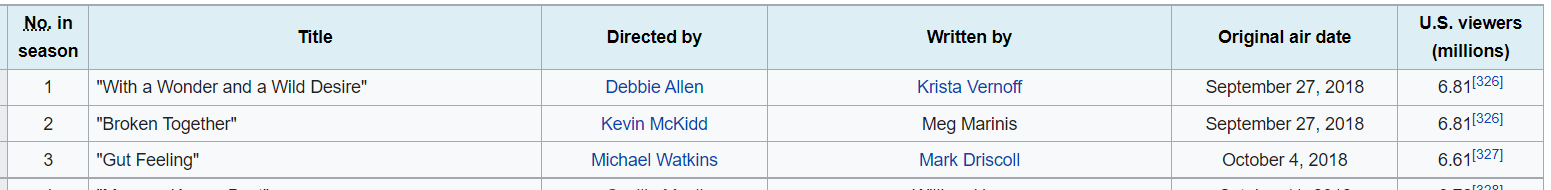

In [164]:
url = "https://en.wikipedia.org/wiki/List_of_Grey%27s_Anatomy_episodes"
r = requests.get(url)
soup = BeautifulSoup(r.content, "html.parser")
row_list = []

for sn in range(1,18):
    table = soup.find_all('table')[sn]
    rows = table.find_all('tr')
    for tr in rows:
        if tr==rows[0]:
            pass #None row
        else:
            td = tr.find_all('td')
            row = [i.text for i in td]
            if sn <= 10:
                row=[value for i,value in enumerate(row) if i != 5]
            row_list.append(row)

#Wiki table to dataframe
GA_views=pd.DataFrame(row_list,columns=["No. Epsiode", "Episode","Directed by","Written by","Aired", "Views"])
#Value settings
GA_views["Views"]=GA_views["Views"].replace(r"\[.*?]", '',regex=True)
GA_views["No. Epsiode"]=pd.to_numeric(GA_views["No. Epsiode"])

Similar to the IMDB data, some episodes with a pt. 1 and pt. 2 are merged into one episode row and therefore we manually adjust the views data to align with no. of rows in the current wiki data table. 

In [178]:
#Find episodes with pt. 1 & pt. 2
GA_views.loc[(GA_views["No. Epsiode"]>30) | (GA_views['Episode']==r'"Dream a Little Dream of Me"')]

,No. Epsiode,Episode,Directed by,Written by,Aired,Views
57,2223,"""The Other Side of This Life""",Michael Grossman,Shonda Rhimes,"May 3, 2007 (2007-05-03)",21.23
75,1617,"""Freedom""",Rob Corn,Shonda Rhimes,"May 22, 2008 (2008-05-22)",18.09
76,12,"""Dream a Little Dream of Me""",Rob CornMichael Pressman,Shonda Rhimes,"September 25, 2008 (2008-09-25)",18.30
238,2223,"""She's Leaving Home""",Chris Hayden,Stacy McKee,"April 30, 2015 (2015-04-30)",8.74


In [179]:
views_list=GA_views.Views.iloc[:58].tolist()
views_list.extend(GA_views.Views.iloc[57:76].tolist())
views_list.extend(GA_views.Views.iloc[75:77].tolist())
views_list.extend(GA_views.Views.iloc[76:].tolist())

Appending retrieved 'views' data to episodes dataframe

In [193]:
GA_episodes['views(milion)']=views_list

<br>

## Transcripts data

The final data attribute to include for the episodes is transcripts. The transcripts provides information of the language used in each episodes. This is very useful when e.g. conducting sentiment analysis.

First, the links to each transcript page are extracted from http://transcripts.foreverdreaming.org/viewforum.php?f=11&start=0 - looping through all pages with the "start=page" parameter. 

In [57]:
trans_link=[]
# Request content from server  and parse with BeautifulSoup
for page in range(0,376,25):
    response = requests.get(f'http://transcripts.foreverdreaming.org/viewforum.php?f=11&start={page}')
    page_html = BeautifulSoup(response.text, 'html.parser')
    for a in page_html.find_all('a',class_="topictitle"):
        trans_link.append(a['href'][1:])

#Excluding non-episode links
trans_link=[link for link in trans_link if '/viewtopic.php?f=11&t=32146&' not in link[:len('/viewtopic.php?f=11&t=32146&')]]
trans_link=[link for link in trans_link if '/viewtopic.php?f=11&t=6456&' not in link[:len('/viewtopic.php?f=11&t=6456&')]]

#Up to and incl. last episode in season 17
last_idx = [idx for idx, s in enumerate(trans_link) if '/viewtopic.php?f=11&t=45210' in s][0]
trans_link=trans_link[:last_idx+1]

Looping through all links stored in `trans_link` all episode transcripts can be retrieved.

In [58]:
all_transcripts=[]
for link in tqdm(trans_link):
    response = requests.get('http://transcripts.foreverdreaming.org'+link)
    page_html = BeautifulSoup(response.text, 'html.parser')
    transcript=[]
    for quote in page_html.find_all('p')[6:]:
        transcript.append(quote.text.strip())
    all_transcripts.append(transcript)

#saving to text files
for num,trans in enumerate(all_transcripts):
    with open(f"./transcripts/episode_{num}.txt", 'w', encoding='utf-8') as f:
        f.write('\n'.join(trans))

Transcript example:

In [60]:
all_transcripts[0][:3] #Season 1, Episode 1

["Meredith VO: The game. They say either a person has what it takes to play, or they don't. My mother was one of the greats. Me, on the other hand...I'm kinda screwed.",
 '(Meredith wakes up on the couch and pulls a blanket off a naked man on the floor, wrapping it around herself. She hits him with a pillow and he grunts, waking up. He lifts up her bra.)',
 'Man: This...is...?']

<br>
The transcripts are added as feature in the episode dataframe.

In [194]:
episode_transcripts=['\n'.join(transcript) for transcript in all_transcripts]
GA_episodes['transcript'] = episode_transcripts
GA_episodes.to_excel('episode_data.xlsx',index=False)

In [195]:
GA_episodes.head()

,season,episode,episode_file,description,quotes,short_summary,airdate,rating,votes,views(milion),transcript
0,1,A Hard Days Night,1_A_Hard_Days_Night,The game. They say a person either has what it...,\n:'''[[Meredith Grey|Meredith]]:''' We don't ...,The first shift for new surgical interns Mered...,27 Mar. 2005,8.4,2417,16.25,Meredith VO: The game. They say either a perso...
1,1,The First Cut Is the Deepest,1_The_First_Cut_Is_the_Deepest,It's all about lines. The finish line at the e...,\n:'''[[Alex Karev|Alex]]:''' Alex Karev. Nice...,"A rape victim is admitted, who managed to hold...",3 Apr. 2005,8.2,1676,17.71,Previously On...\nWebber: The seven years you ...
2,1,Winning a Battle Losing the War,1_Winning_a_Battle_Losing_the_War,We live out our lives on the surgical unit. Se...,"\n:'''[[Cristina Yang|Cristina]]:''' Oh, it's ...",Izzie and Cristina are assigned a close-to-bra...,10 Apr. 2005,8.1,1568,17.99,Meredith's in bed. It's 4:37am and raining.\nM...
3,1,No Mans Land,1_No_Mans_Land,"Intimacy is a four syllable word for \""Here is...",\n:'''[[Meredith Grey|Meredith]]:''' Where are...,"Alex uses Izzie's modeling against her, and he...",17 Apr. 2005,8.1,1489,19.18,(Opens seeing Meredith through a rain covered ...
4,1,Shake Your Groove Thing,1_Shake_Your_Groove_Thing,Remember when you were a kid and your biggest ...,\n:'''[[George O'Malley|George]]:''' Who else ...,Meredith worries she did something wrong durin...,24 Apr. 2005,8.2,1440,17.90,(Music: The Ditty Bops-Wake Up)\n(Meredith sit...


<br>
Finally, the data for describing each episode in Grey's Anatomy has been retrieved and stored in a dataframe. <br>


# Data Summary
The full data which will be used in this project is outlined below<br><br>


**Character Data**
* character_names.xlsx
    *  Name (Wiki)
* Character text files (Stored in 'character_files' folder)
    * From the text files the features of each character will be extracted in "*Explainer Notebook*"

**Episode Data**
* episode_data.xlsx
    * Season -- (Wiki)
    * Episode Name -- (Wiki)
    * Description -- (Wiki)
    * Quotes -- (Wiki)
    * Short Summary (IMDB)
    * Air Date -- (IMDB)
    * Rating -- (IMDB)
    * No. Views -- (Wikipedia)
    * No. Votes -- (IMDB)
    * Transcripts -- (foreverdreaming.org)
    
    
* Episode text files in folders:
    * full_episode_files
    * quote_files
    * transcripts
    * descriptions_monologues (descriptions + transcripts combined)